<a href="https://colab.research.google.com/github/WNderitu/Malaria-Parasite-Detector-version-2/blob/main/2_model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plasmodium Vivax (malaria) parasite detector and counter**

**Notebook 2: Model training Notebook**

- YOLOv8n model variant/size

In [1]:
from google.colab import drive

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully!


## **2.0 Install & import required libraries**

In [2]:
!pip install matplotlib --quiet

In [3]:
!pip install Pillow --quiet #installing PILLOW LIBRARY

In [4]:
!pip install imagehash --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.5 MB/s eta 0:00:00


In [5]:
!pip install pyyaml --quiet

In [6]:
import requests
import os
import json
import random
import shutil # For copying images & creating dirctories
from PIL import Image # Import Image to get image dimensions
from pprint import pprint # for
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
import hashlib # find identical images
from collections import defaultdict
import numpy as np
import math # for mathematical calculations
import yaml # For generating data.yaml
from collections import Counter # Import Counter to get class counts
import pandas as pd
import matplotlib.patches as mpatches

## 2.2 Model Training

In [ ]:
# Install ultralytics
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00


### 2.2.1 Training

#### *Train 1*

In [ ]:
from ultralytics import YOLO
import torch

# Paths
yaml_path = '/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml'
save_dir = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results'
run_name = 'yolov8n_malaria_train_1'

# Initialize Model
model = YOLO('yolov8n.pt')

class_weights = torch.tensor([0.1487, 94.8877, 54.6002, 22.1620, 27.6868, 6.6350, 67.8710],dtype=torch.float32,device="cuda")

# Apply class weights ONCE when loss first appears
class_weights_applied = False

def apply_class_weights(trainer):
    global class_weights_applied
    if not class_weights_applied and trainer.loss is not None:
        trainer.loss.class_weights = class_weights
        class_weights_applied = True
        print("\n✅ Class weights successfully applied to YOLO loss.\n")

model.add_callback("on_train_batch_start", apply_class_weights)

# Training
print(f"🚀 Starting training for {run_name}...")

results = model.train(
    data=yaml_path,
    project=save_dir,
    name=run_name,

    # --- Critical for 1600x1200 Images on T4 ---
    imgsz=1280,              # High Res: Vital for seeing tiny parasites.
    batch=8,                 # Lower batch size to fit 1280px images in T4 VRAM
    cache=True,              # SPEED BOOST: Loads all 1031 images into RAM

    # --- Training Mechanics ---
    epochs=500,
    patience=300,
    device=0,
    optimizer='AdamW',
    workers=2,               # Colab usually allows 2 workers
    exist_ok=True,
    verbose=False,
    amp=True,
    lr0=0.001,

    # --- Augmentations for Microscopy ---
    # small object augmentations
    # These are tuned to preserve biological features while handling rotation
    mosaic=1.0,
    mixup=0.0,               # DISABLE: Overlapping cells confuses small parasite detection
    copy_paste=0.0,          # DISABLE: Keep it clean for small datasets
    close_mosaic=50,         # turn mosaic off for the last 50 epochs for stable convergence

    # Color (Conservative to preserve stain colors)
    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.4,

    # Geometry (Blood cells rotate 360 degrees)
    degrees=180.0,           # Full rotation allowed
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.5,
    fliplr=0.5,

    cls=True,                # turn on class loss for higher recall
    box=True                 # increased box loss for more tighter localization of tiny bounding boxes
)

print(f"\nTraining complete. Results saved to {save_dir}/{run_name}")
print("Check the training logs above to confirm if class weights were applied.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Starting training for yolov8n_malaria_train_1...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=True, cache=True, cfg=None, classes=None, close_mosaic=50, cls=True, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml, degrees=180.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=Fals

KeyboardInterrupt: 

Training interrupted as there was no improvement in metrics from epoch 177. Yes. The YOLOv8n metrics were not improving for many epochs.

#### *Start of fine tuning* -- aggresssive decay of learning rate implemented

In [ ]:
from ultralytics import YOLO
import torch
import os

# paths
yaml_path = '/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml'
save_dir = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results'
run_name = 'yolov8n_malaria_train_1'

# The model path must point to the 'last.pt' file (contains Epoch 238 state)
model_path = os.path.join(save_dir, run_name, 'weights', 'last.pt')


# --- 2. AGGRESSIVE DECAY AND OVERRIDE PARAMETERS ---
# 🚨 DECAY FACTOR APPLIED: Initial LR reduced 10x from 0.001 to 0.0001
NEW_INITIAL_LR = 0.0001
NEW_FINAL_LR = 0.000001

# Set the new total epochs for the planned early stop
NEW_EPOCHS = 300

# Patience is the number of epochs without mAP50-95 improvement before stopping.
NEW_PATIENCE = 50


# --- 3. CUSTOM CLASS WEIGHTS SETUP (REQUIRED FOR LOSS FUNCTION) ---
class_weights = torch.tensor([0.1487, 94.8877, 54.6002, 22.1620, 27.6868, 6.6350, 67.8710],
                             dtype=torch.float32,
                             device="cuda")
class_weights_applied = False

def apply_class_weights(trainer):
    """Callback function to inject custom class weights into the loss function."""
    global class_weights_applied
    if not class_weights_applied and trainer.loss is not None:
        trainer.loss.class_weights = class_weights
        class_weights_applied = True
        print("\n✅ Custom class weights successfully applied to YOLO loss on resume.\n")
    # Log the current LR to confirm the decay is active
    current_lr = trainer.optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.8f} (Aggressive Decay Active)")


# --- 4. INITIALIZE AND RESUME TRAINING ---
try:
    # 1. Load the interrupted model's checkpoint.
    print(f"Loading model checkpoint from: {model_path}")
    model = YOLO(model_path)

    # 2. Re-apply the custom callback before starting training.
    model.add_callback("on_train_batch_start", apply_class_weights)

    # 3. Resume training with aggressive LR decay and overrides.
    print(f"🔄 Resuming training from Epoch 239 up to Epoch {NEW_EPOCHS} with:")
    print(f"   - NEW Initial LR (lr0): {NEW_INITIAL_LR}")
    print(f"   - NEW Final LR (lrf): {NEW_FINAL_LR}")
    print(f"   - NEW Patience: {NEW_PATIENCE} epochs")

    results = model.train(
        # Resume flag loads all previous settings from last.pt
        resume=True,

        # --- Override Parameters ---
        lr0=NEW_INITIAL_LR,
        lrf=NEW_FINAL_LR,
        epochs=NEW_EPOCHS,
        patience=NEW_PATIENCE,

        # Ensure correct project structure and GPU usage
        data=yaml_path,
        project=save_dir,
        name=run_name,
        device=0 # device=0 specifies the first GPU (your T4)
    )

    print(f"\nTraining complete. Results saved to {save_dir}/{run_name}")

except FileNotFoundError:
    print(f"\nFATAL ERROR: Checkpoint file not found at {model_path}")

except Exception as e:
    print(f"\nAn unexpected error occurred during training resume: {e}")

Loading model checkpoint from: /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/weights/last.pt
🔄 Resuming training from Epoch 239 up to Epoch 300 with:
   - NEW Initial LR (lr0): 0.0001
   - NEW Final LR (lrf): 1e-06
   - NEW Patience: 50 epochs
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=True, cache=True, cfg=None, classes=None, close_mosaic=50, cls=True, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml, degrees=180.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, k

KeyboardInterrupt: 

Train interrupted as the learning rate override was not applied correctly in the first batch of Epoch 239.

#### *2nd try: correct application of learning rate override*

In [ ]:
from ultralytics import YOLO
import torch
import os

# --- CONFIGURATION ---
model_path = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/weights/last.pt'
yaml_path = '/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml'
save_dir = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results'
run_name = 'yolov8n_malaria_train_1'

# --- AGGRESSIVE DECAY PARAMETERS ---
NEW_INITIAL_LR = 0.0001
NEW_FINAL_LR = 0.000001
NEW_EPOCHS = 300
NEW_PATIENCE = 50

# --- LOAD MODEL & EXTRACT STATE ---
print(f"Loading model checkpoint from: {model_path}")
model = YOLO(model_path)
# FIX APPLIED HERE: weights_only=False to allow unpickling of custom classes
model_checkpoint = torch.load(model_path, map_location=model.device, weights_only=False)

# --- CRITICAL: DIRECTLY MODIFY OPTIMIZER STATE ---
print("⚙️ Directly modifying optimizer learning rate and scheduler state...")

optimizer_state = model_checkpoint.get('optimizer')

if optimizer_state and 'param_groups' in optimizer_state:
    for i, param_group in enumerate(optimizer_state['param_groups']):
        param_group['lr'] = NEW_INITIAL_LR

    print(f"✅ Optimizer LR reset successful. New Base LR: {NEW_INITIAL_LR:.6f}")
else:
    print("⚠️ Warning: Could not find or modify optimizer state in the checkpoint.")

# --- SAVE THE MODIFIED CHECKPOINT ---
modified_checkpoint_path = model_path.replace('last.pt', 'last_modified.pt')
torch.save(model_checkpoint, modified_checkpoint_path)
print(f"💾 Saved modified checkpoint to: {modified_checkpoint_path}")

# --- CUSTOM CLASS WEIGHTS SETUP (Re-inserting the callback) ---
# Define class weights tensor
class_weights = torch.tensor([0.1487, 94.8877, 54.6002, 22.1620, 27.6868, 6.6350, 67.8710],
                             dtype=torch.float32,
                             device=model.device)
class_weights_applied = False

def apply_class_weights(trainer):
    global class_weights_applied
    if not class_weights_applied and hasattr(trainer, 'loss') and trainer.loss is not None:
        trainer.loss.class_weights = class_weights
        class_weights_applied = True
        print("\n✅ Custom class weights successfully applied to YOLO loss via callback.\n")

    current_lr = trainer.optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate Check: {current_lr:.8f}")


# 1. Load the modified checkpoint to start training with the correct initial LR
model_to_train = YOLO(modified_checkpoint_path)

# 2. Re-apply the callback for class weights
model_to_train.add_callback("on_train_batch_start", apply_class_weights)

# 3. Resume training, passing the new config arguments
print(f"\n🔄 Resuming training from Epoch 239 up to Epoch {NEW_EPOCHS} using MODIFIED checkpoint...")

results = model_to_train.train(
    resume=True,
    lr0=NEW_INITIAL_LR,
    lrf=NEW_FINAL_LR,
    epochs=NEW_EPOCHS,
    patience=NEW_PATIENCE,
    data=yaml_path,
    project=save_dir,
    name=run_name,
    device=0,
)

Loading model checkpoint from: /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/weights/last.pt
⚙️ Directly modifying optimizer learning rate and scheduler state...
✅ Optimizer LR reset successful. New Base LR: 0.000100
💾 Saved modified checkpoint to: /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/weights/last_modified.pt

🔄 Resuming training from Epoch 239 up to Epoch 300 using MODIFIED checkpoint...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=True, cache=True, cfg=None, classes=None, close_mosaic=50, cls=True, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml, degrees=180.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, e

KeyboardInterrupt: 

#### *3rd try: GPU resources timed out. Changed drive*

In [ ]:
import os
import yaml
from ultralytics import YOLO
import torch

# --- 0. CONFIGURATION ---
RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1'
ARGS_YAML_PATH = os.path.join(RUN_DIR, 'args.yaml')
MODIFIED_CHECKPOINT_PATH = os.path.join(RUN_DIR, 'weights', 'last_modified.pt')
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml'
SAVE_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results'
RUN_NAME = 'yolov8n_malaria_train_1'

# --- 1. NEW HYPERPARAMETERS TO INJECT ---
NEW_EPOCHS = 300
NEW_PATIENCE = 50
NEW_LR0 = 0.0001
NEW_LRF = 0.000001

# --- 2. DYNAMICALLY OVERWRITE THE ARGS.YAML (SAFEGUARD) ---
print("Attempting to overwrite the conflicting args.yaml file...")
try:
    with open(ARGS_YAML_PATH, 'r') as f:
        args_data = yaml.safe_load(f)

    args_data['epochs'] = NEW_EPOCHS
    args_data['patience'] = NEW_PATIENCE
    args_data['lr0'] = NEW_LR0
    args_data['lrf'] = NEW_LRF

    with open(ARGS_YAML_PATH, 'w') as f:
        yaml.safe_dump(args_data, f)

    print(f"✅ Successfully OVERWROTE {ARGS_YAML_PATH} with:\n   - epochs: {NEW_EPOCHS}\n   - lr0: {NEW_LR0}\n   - patience: {NEW_PATIENCE}")
except Exception as e:
    print(f"🛑 CRITICAL ERROR: Could not read or write args.yaml. Error: {e}")


# --- 3. CUSTOM CLASS WEIGHTS SETUP ---
# Ensure these weights are correct for your 7 classes (Malaria dataset)
class_weights = torch.tensor([0.1487, 94.8877, 54.6002, 22.1620, 27.6868, 6.6350, 67.8710],
                             dtype=torch.float32,
                             device='cpu') # Changed device to 'cpu'
class_weights_applied = False

def apply_class_weights(trainer):
    global class_weights_applied
    if not class_weights_applied and hasattr(trainer, 'loss') and trainer.loss is not None:
        trainer.loss.class_weights = class_weights
        class_weights_applied = True
        print("\n✅ Custom class weights successfully applied to YOLO loss via callback.\n")


# --- 4. RESUME TRAINING with FORCED ARGUMENTS (THE FIX) ---
print(f"\nLoading modified checkpoint from: {MODIFIED_CHECKPOINT_PATH}")
model_to_train = YOLO(MODIFIED_CHECKPOINT_PATH)

model_to_train.add_callback("on_train_batch_start", apply_class_weights)

print("\n🔄 Resuming training. FORCING the new hyperparameters via train() arguments.")

# The arguments passed here take precedence over the saved args.yaml
results = model_to_train.train(
    # --- FORCED FINE-TUNING ARGUMENTS ---
    epochs=NEW_EPOCHS,      # Max epochs set to 300
    patience=NEW_PATIENCE,  # Early stopping set to 50
    lr0=NEW_LR0,            # Starting Learning Rate set to 0.0001
    lrf=NEW_LRF,            # Final Learning Rate factor set to 0.000001
    # ------------------------------------

    verbose=False,
    resume=True,
    data=DATA_YAML_PATH,
    project=SAVE_DIR,
    name=RUN_NAME,
    device='cpu' # Changed device to 'cpu'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Attempting to overwrite the conflicting args.yaml file...
✅ Successfully OVERWROTE /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/args.yaml with:
   - epochs: 300
   - lr0: 0.0001
   - patience: 50

Loading modified checkpoint from: /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/weights/last_modified.pt

🔄 Resuming training. FORCING the new hyperparameters via train() arguments.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=True, cache=True, cfg=Non

Exception in thread Thread-14 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_

KeyboardInterrupt: 

Training stopped as there is no much improvement to prevent overfitting.

#### *Summary of training and validation results*

In [7]:
RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1'
SAVE_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results'
RUN_NAME = 'yolov8n_malaria_train_1'

# Define the path to the results.csv file
results_csv_path = os.path.join(SAVE_DIR, RUN_NAME, 'results.csv')

# Check if the results.csv file exists
if os.path.exists(results_csv_path):
    # Load the results into a pandas DataFrame
    # Skip the first row as it often contains headers with extra '#' characters
    df_results = pd.read_csv(results_csv_path)

    # The first row often contains additional '#' comments. Clean column names.
    df_results.columns = [col.strip().replace(' ', '').replace('#', '') for col in df_results.columns]

    # Assuming the first column is 'epoch' (or similar)
    # Find the maximum epoch reached in the logs. The epoch numbers in the CSV are 0-indexed if using default YOLOv8 behavior or may directly reflect actual epoch numbers.
    # Let's check the first column for 'epoch' or similar identifier
    epoch_col = [col for col in df_results.columns if 'epoch' in col.lower()][0] if any('epoch' in col.lower() for col in df_results.columns) else None

    if epoch_col:
        # Filter data up to the requested epoch (354)
        summary_until_epoch = df_results[df_results[epoch_col] <= 354]
        print(f"Model summary until epoch 354 from '{results_csv_path}':")
        display(summary_until_epoch)
    else:
        print("Could not find an 'epoch' column in the results.csv file.")
        display(df_results)

else:
    print(f"Error: results.csv not found at {results_csv_path}")
    print("Please ensure training completed successfully and generated the results file.")

Model summary until epoch 354 from '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/results.csv':


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,63.6857,0.17183,3.42286,1.33043,0.26781,0.12064,0.13150,0.06837,0.19744,2.44479,1.34290,0.067317,0.000330,0.000330
1,2,121.4870,0.14184,2.03525,1.18704,0.56186,0.13408,0.14539,0.07087,0.20324,2.34964,1.41581,0.034316,0.000662,0.000662
2,3,178.8210,0.14296,1.83984,1.20393,0.79125,0.34156,0.27467,0.15118,0.16590,1.57700,1.23374,0.001313,0.000993,0.000993
3,4,236.5440,0.13388,1.53929,1.15211,0.41026,0.62176,0.31488,0.16520,0.20999,1.46825,1.41167,0.000994,0.000994,0.000994
4,5,292.7990,0.12956,1.41108,1.13439,0.55205,0.41164,0.31566,0.16423,0.21305,1.40566,1.41350,0.000992,0.000992,0.000992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,350,4916.4900,0.08824,0.62772,1.18941,0.68533,0.75778,0.76447,0.53468,0.15490,0.80765,1.69120,0.000309,0.000309,0.000309
350,351,4973.6700,0.08850,0.62921,1.21178,0.72581,0.72829,0.76887,0.53699,0.15591,0.80305,1.68568,0.000307,0.000307,0.000307
351,352,5030.0700,0.08759,0.63412,1.20936,0.74258,0.71694,0.76886,0.52531,0.15805,0.80307,1.71129,0.000305,0.000305,0.000305
352,353,5086.0700,0.08928,0.63638,1.20599,0.70070,0.76648,0.76492,0.52024,0.16288,0.82071,1.76715,0.000303,0.000303,0.000303


#### *Summary statistics of train results*

In [ ]:
display(df_results.describe())

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,177.500000,5178.380634,0.095345,0.737452,1.098036,0.678621,0.735353,0.729311,0.499604,0.157665,0.845473,1.339277,0.000933,0.000648,0.000648
std,102.335233,3868.894104,0.010407,0.258187,0.254021,0.079195,0.072079,0.096983,0.073930,0.020142,0.280792,0.309105,0.003970,0.000202,0.000202
min,1.000000,60.252700,0.087590,0.627720,0.993240,0.054320,0.120640,0.060500,0.037690,0.106500,0.668180,0.968250,0.000301,0.000301,0.000301
25%,89.250000,1822.347500,0.090815,0.654400,1.007048,0.665628,0.722780,0.744552,0.498125,0.145797,0.767857,1.095862,0.000476,0.000474,0.000474
50%,177.500000,4291.630000,0.092735,0.680150,1.018525,0.694460,0.746605,0.758135,0.513500,0.159400,0.812005,1.194375,0.000651,0.000649,0.000649
75%,265.750000,8334.602500,0.095810,0.726953,1.210217,0.722318,0.766185,0.767977,0.531162,0.169225,0.857322,1.667305,0.000825,0.000821,0.000821
max,354.000000,13181.000000,0.208510,3.693820,5.456660,0.797250,0.823720,0.787880,0.582910,0.216080,5.247830,2.078500,0.067317,0.000994,0.000994


#### Error Analysis: Train 1

*Training & Validation Classification Loss Curves*

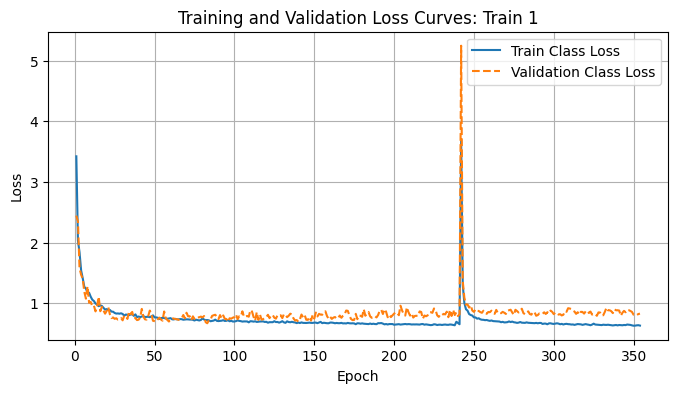

In [8]:
plt.figure(figsize=(8,4))
plt.plot(df_results['epoch'], df_results['train/cls_loss'], label='Train Class Loss', linestyle='-')
plt.plot(df_results['epoch'], df_results['val/cls_loss'], label='Validation Class Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves: Train 1')
plt.legend()
plt.grid(True)
plt.show()

Training and Validation Bounding Box Loss Curves

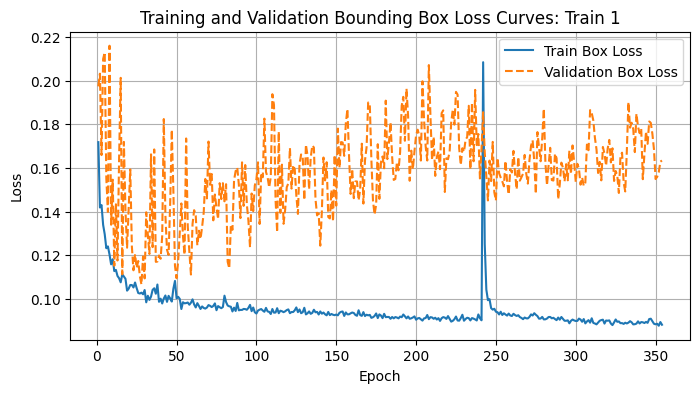

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df_results['epoch'], df_results['train/box_loss'], label='Train Box Loss', linestyle='-')
plt.plot(df_results['epoch'], df_results['val/box_loss'], label='Validation Box Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Bounding Box Loss Curves: Train 1')
plt.legend()
plt.grid(True)
plt.show()

*Training and Validation Distribution Focal Loss Curves*

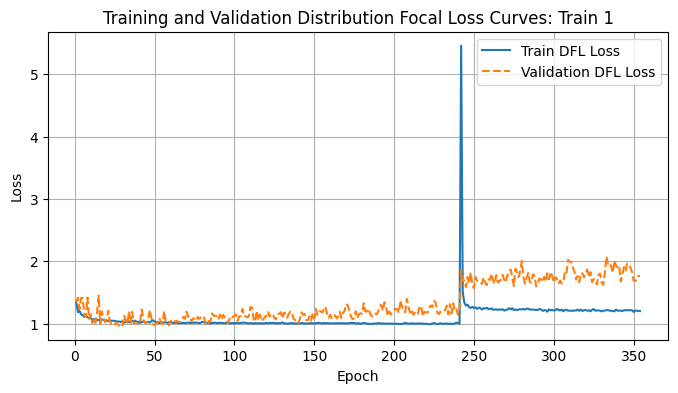

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df_results['epoch'], df_results['train/dfl_loss'], label='Train DFL Loss', linestyle='-')
plt.plot(df_results['epoch'], df_results['val/dfl_loss'], label='Validation DFL Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Distribution Focal Loss Curves: Train 1')
plt.legend()
plt.grid(True)
plt.show()

*Total Training and Validation Loss Curves*

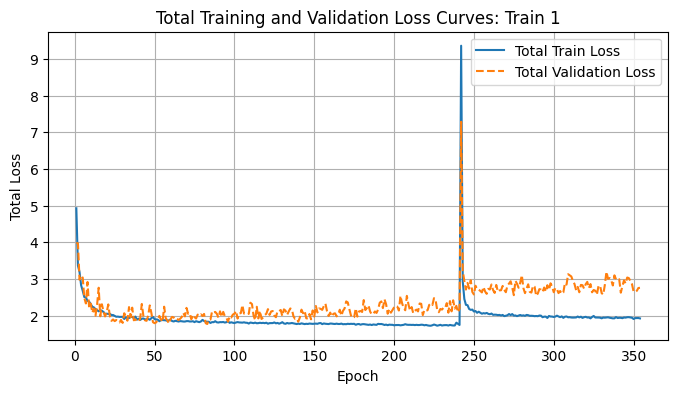

In [12]:
import matplotlib.pyplot as plt

# Calculate total training and validation losses
df_results['total_train_loss'] = df_results['train/box_loss'] + df_results['train/cls_loss'] + df_results['train/dfl_loss']
df_results['total_val_loss'] = df_results['val/box_loss'] + df_results['val/cls_loss'] + df_results['val/dfl_loss']

plt.figure(figsize=(8,4))
plt.plot(df_results['epoch'], df_results['total_train_loss'], label='Total Train Loss', linestyle='-')
plt.plot(df_results['epoch'], df_results['total_val_loss'], label='Total Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Training and Validation Loss Curves: Train 1')
plt.legend()
plt.grid(True)
plt.show()

#### *Loss curves*

Initial Learning Phase: Both training and validation loss curves show a sharp decrease during the early epochs. This is a normal and healthy sign, indicating that the model is quickly learning from the training data and improving its performance on both seen and unseen data.

Convergence and Stability: As training progresses, all loss curves continue to decrease, albeit at a slower rate, and eventually start to flatten out. This suggests that the model is converging towards an optimal state, where further training yields diminishing returns.

Generalization Performance: The validation loss curves closely track the training loss curves. This is a very positive indicator! A small and stable gap between training and validation losses suggests that the model is generalizing well to new, unseen data and is not significantly overfitting. If the validation loss were to start increasing significantly while training loss continues to decrease, that would be a strong sign of overfitting, which we don't observe here.

Fine-tuning Impact (from epoch ~240 onwards): Looking at the results.csv data (though not explicitly plotted with a vertical line to indicate the exact epoch of fine-tuning restart), the second phase of training with aggressive learning rate decay seems to have allowed for continued, albeit slow, refinement of the model, maintaining a good balance between training and validation performance.

In conclusion, the combined loss curves suggest that the model has learned effectively and generalizes well to the validation dataset, without clear signs of overfitting or underfitting within the observed training period.

#### *Validation metric curves*

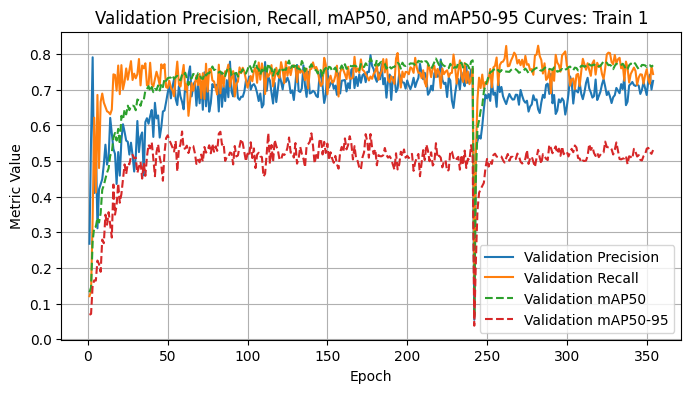

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(df_results['epoch'], df_results['metrics/precision(B)'], label='Validation Precision', linestyle='-')
plt.plot(df_results['epoch'], df_results['metrics/recall(B)'], label='Validation Recall', linestyle='-')
plt.plot(df_results['epoch'], df_results['metrics/mAP50(B)'], label='Validation mAP50', linestyle='--')
plt.plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'], label='Validation mAP50-95', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Precision, Recall, mAP50, and mAP50-95 Curves: Train 1')
plt.legend()
plt.grid(True)
plt.show()

Initial Improvement: Similar to the loss curves, all validation metrics (Precision, Recall, mAP50, and mAP50-95) show a steep increase in the early epochs. This signifies rapid learning and improved detection capabilities on the validation set.

Convergence and Fluctuations: After the initial rise, the metrics continue to improve, but with some fluctuations. This is normal in deep learning training, where the model might slightly overfit or underfit specific batches, causing minor ups and downs in validation performance.

Overall Trend: All metrics generally trend upwards or stabilize at high values towards the later epochs. This indicates that the model is consistently performing well on the validation data. Specifically:

Precision and Recall: These curves show a good balance. A high precision means the model is good at not making false detections, while high recall means it's good at finding most of the actual objects.

mAP50: This metric often stabilizes at a higher value, as it's less strict regarding bounding box accuracy.

mAP50-95: This is a more challenging metric, requiring highly accurate bounding box localization in addition to correct classification. Its improvement, even if less dramatic than mAP50, is a strong indicator of robust object detection.

Absence of Overfitting (General): Crucially, we don't observe a significant drop in validation metrics while training losses continue to decrease sharply. This suggests that the model is not severely overfitting to the training data. The metrics generally stabilize, indicating that the model has learned generalizable features.

#### *F1 scores*

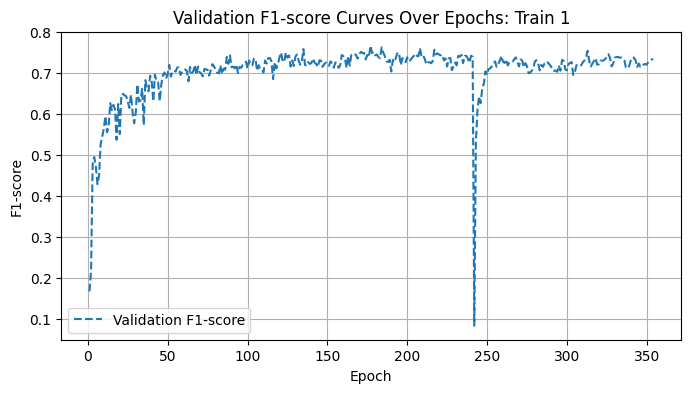

In [15]:
# Calculate F1-scores for all epochs
# Adding F1-score columns to the DataFrame

def calculate_f1(row):
    precision = row['metrics/precision(B)']
    recall = row['metrics/recall(B)']
    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0.0

df_results['val_f1'] = df_results.apply(calculate_f1, axis=1)

# Plotting F1-scores
plt.figure(figsize=(8,4))
plt.plot(df_results['epoch'], df_results['val_f1'], label='Validation F1-score', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score Curves Over Epochs: Train 1')
plt.legend()
plt.grid(True)
plt.show()

**Initial Improvement:** Show a rapid increase in the early epochs. This is consistent with the other metrics (loss, precision, recall) and indicates that the model quickly learns to effectively detect and classify objects.

**High Performance and Stability:** After the initial steep rise, F1-score curve reaches high values and generally remain stable. This signifies that the model has achieved a strong and consistent performance in terms of balancing precision and recall.

**Overall Effectiveness:** A high F1-score indicates that the model is effective at both correctly identifying positive cases (high recall) and doing so with a low rate of false positives (high precision). The stability of these scores towards the end of training suggests a robust model.

### *2.2.2 Best model validation on val image subset*

#### Setup & Validation

In [ ]:
from ultralytics import YOLO

# Setup and Validation
# evaluation of best model perfomance on the validation images subset (206 images)

# Define paths
RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1'
BEST_MODEL_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_dataset/data.yaml'

# Load best trained model from Train 1
if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading best model from: {BEST_MODEL_PATH}")
    model = YOLO(BEST_MODEL_PATH)

    # Validate the model on the validation set to generate plots, including confusion matrix
    print("Running validation on the validation set to generate the confusion matrix...")
    results_val = model.val(
        data=DATA_YAML_PATH,
        split='val', # Explicitly validate on the validation set
        imgsz=1280,
        batch=8,
        device='cpu', # Changed device to 'cpu'
        project=RUN_DIR,
        name='val_evaluation', # Name for this evaluation run
        plots=True, # Ensure plots are generated (including confusion matrix)
        save_json=True, # Save results as json
        verbose=True,
        exist_ok=True
    )
    print("Validation complete. Confusion matrix and other plots should be saved in the run directory.")

else:
    print(f"Error: Best model not found at {BEST_MODEL_PATH}")
    print("Please ensure the training completed successfully and 'best.pt' was saved.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading best model from: /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/weights/best.pt
Running validation on the validation set to generate the confusion matrix...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.2 ms, read: 53.3±106.9 MB/s, size: 1764.7 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_dataset/labels/val.cache... 206 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 206/206 186.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R   

**Performance on all classes**

- **mAP50-95 (Overall Quality) 0.581** - final performance benchmark,very good result for the challenging task of detecting multiple tiny classes (malaria parasites) under strict IoU thresholds.

- **mAP50	0.743** - Good performance. Model detects objects with at least 50% accuracy at a relaxed Intersection over Union (IoU) threshold of 0.5.

- **Precision 0.665** - 66.5% of all predictions made by the model were correct (True Positives).

- **Recall 0.740** - model successfully found 74.0% of all actual objects in the dataset (True Positives).

----------------------------------------


**Per-class metrics:**

| Class Name       | Precision (P) | Recall (R) | mAP50 | mAP50-95 | comment |
|------------------|---------------|------------|-------|----------| ------------- |
| **red blood cell**   | 0.959         | 0.992      | 0.993 | 0.783    | Very good. High Precision means low False Positives; high Recall means it found almost every cell. This is expected due to the large number of instances.
| **leukocyte**        | 0.942         | 0.857      | 0.909 | 0.667    | Good. High performance despite the low instance count (only 19).
| **schizont**         | 0.411         | 0.476      | 0.527 | 0.408    | Poor. Low scores indicate the model struggles significantly to both correctly identify and locate this less frequent stage.
| **difficult**       | 0.414         | 0.546      | 0.482 | 0.389    | Poor. Low scores across the board, which is expected for a subjective 'difficult' class.
| **ring**             | 0.75          | 0.716      | 0.804 | 0.664    | Good. The model is quite accurate at identifying the small 'ring' stage.
| **trophozoite**      | 0.752         | 0.808      | 0.829 | 0.615    | Good. Strong performance for a parasite stage, indicating the model handles this common stage well.
| **gametocyte**       | 0.43          | 0.783      | 0.657 | 0.542    | Mixed. High Recall suggests it finds most gametocytes, but low Precision (0.43) means more than half its gametocyte predictions are False Positives (it often mistakes other objects for a gametocyte).
---------------------------------------


**Observations:**

*   **Red blood cells** & **leukocytes**: show very high precision & recall, contributing significantly to the overall mAP. Indicates the model is excellent at detecting these classes.
*   **Schizonts**, **difficult** & **gametocytes**: lower precision & mAP values compared to other classes. Suggests that the model struggles more with accurate detection & localization for these specific parasite stages, possibly due to their smaller size, variability in appearance, or fewer instances in the dataset.
*   **Ring** & **trophozoite** stages perform moderately well, with reasonable precision & recall values.

#### *Confusion matrix*

Displaying confusion matrix from: /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/val_evaluation/confusion_matrix.png


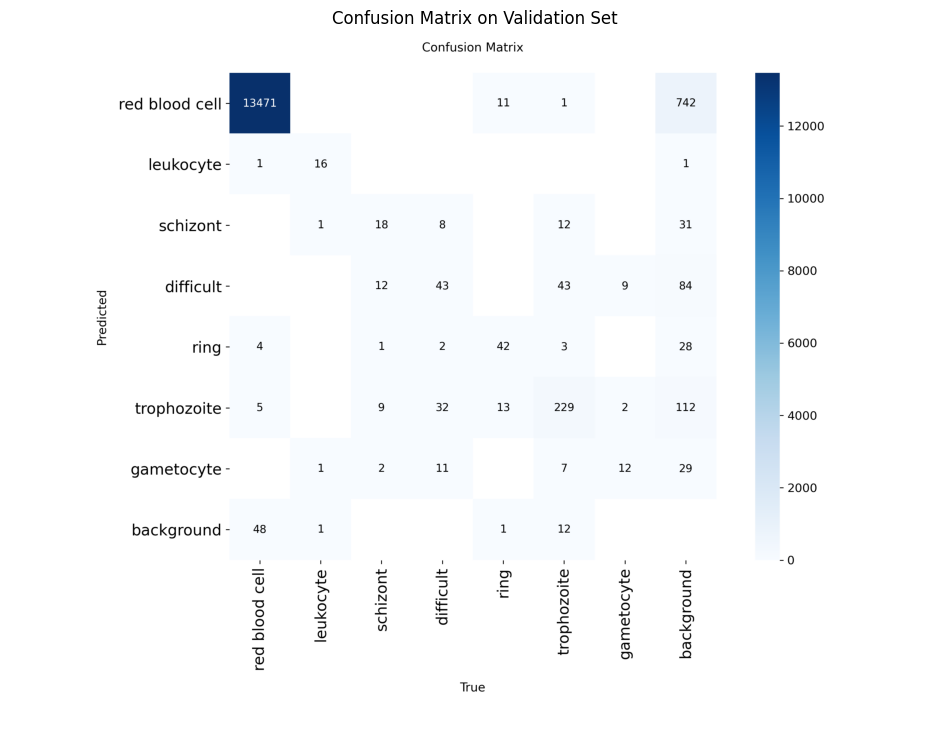

In [ ]:
# Find generated confusion matrix plot (assuming the validation run in the first block was successful) and displaying it using Matplotlib.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os # Included again for block separation and robustness

# Define paths (re-defined or assumed to be available from the previous run)
RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1'
# Define the path to the generated confusion matrix plot
# YOLOv8 typically saves plots in the named validation run folder.
confusion_matrix_path = os.path.join(RUN_DIR, 'val_evaluation', 'confusion_matrix.png')

# Display the confusion matrix
if os.path.exists(confusion_matrix_path):
    print(f"Displaying confusion matrix from: {confusion_matrix_path}")
    #
    img = mpimg.imread(confusion_matrix_path)
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.title('Confusion Matrix on Validation Set')
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Confusion matrix plot not found at {confusion_matrix_path}")
    print("Please ensure the validation step ran successfully and check the output directory for generated plots.")

**Analysis of Confusion Matrix:**

**1**. **High-Performing Classes** **(Diagonal Dominance)**.Classes where large numbers are concentrated on the diagonal (True = Predicted) are performing well.
  - **Red Blood Cell (RBC)**:**Model correctly predicted 13,471 RBCs**. There are almost no False Positives for this class (only 11 misclassified as 'ring' and 1 as 'leukocyte'), which explains the **95.9%** Precision.
  - **Leukocyte:16 instances out of 19 correctly identified**. Only 1 was misclassified as RBC. Explains high **94.2%** Precision.
  - **Trophozoite:** Model predicted **correctly 229 out of 307 instances.** Hence 80.8 % on recall.
  - **Ring:** **correctly predicted 42 instances out of 67.**

**2.** **Classes with Low Precision (Row Analysis)**. A row with high off-diagonal numbers means the model falsely predicted that class often (low Precision).
  - **Schizont:** When the model predicted Schizont **8(r0w3)**, only 18 out of 42 instances were truly schizont.It **misclassified 12 as trophozoites** & 8 as difficult.
  - **Difficult:** When the model predicted Difficult **(row 4)**, only 43 were truly Difficult. It misclassified **43 trophozoites**, 12 schizonts & 9 gametocytes as Difficult. This indicates the "Difficult" class acts as a catch-all for ambiguous parasite stages.
  - **Gametocyte:** When the model predicted Gametocyte **(row 7)**, only 12 were truly Gametocyte. However, it predicted **11 Difficult, 7 Trophozoites**, 2 schizonts & 1 leukocyte as gametocytes when the true label was something else, contributing to the low 43% Precision.
  
**3.** **Classes with Low Recall (Column Analysis).** A column with high off-diagonal numbers means the model failed to find many instances of that true class (low Recall).
  - **Schizont:** When the true label was Schizont (column 3), the model only correctly identified 18. It missed **12 by classifiying as Difficult**, 9 as Trophozoite, 2 as gametocyte & 1 as ring. The 47.6 % Recall is due to these misses and others falling into the 'Difficult' category.
  - **Gametocyte:** When the true label was Gametocyte (column 6), the model correctly identified 12 but missed **9 by classifying them as 'Difficult'**.

  ------------------------
  
**🎯 Summary for Fine-Tuning**

The matrix provides the rationale for your fine-tuning strategy:
- **Reduce Confusion with Difficult:** Difficult with gametocytes, schizont & trophozoites
- **Reduce Confusion with Trophozoite:** The biggest confusion is between Trophozoite (True) and Difficult (Predicted) and Trophozoite (Predicted) and Schizont (True).
- **Target Schizont and Gametocyte:** The model is not learning the features of Schizont and Gametocyte well. Schizont is often confused with Trophozoite (9 instances) and Gametocyte is confused with Trophozoite and Difficult.
- **Consider removing Difficult class entirely**, either remove annotations ot check which parasite class the annotations can be merged with.

## **2.3 Recommendations for Hyperparameter Tuning**

1. **Consider removing Difficult class entirely**, either remove annotations or check which parasite class the annotations can be merged with. Check which parasite class is most similar in size to difficult class. This will most likely be Trophozoite as this is the class most often confused with Difficult class (43 instances) and likely occur together in an microscopic image. The total number of parasites will still be maintained with this strategy, likely improve model performance & have clear class boundaries. Also during deployment, there will be no Difficult class to predict making the model clinically acceptable.
*  - Note, the class Difficult was allowed when annotators had difficulty attributing a parasite class to the 5 defined malaria parasite stages, so it's not an actual biological class but labeler uncertainity of what class of parasite the parasite belongs to.*
2. **Schizont**, worst performing class. **Increase its class weight** significantly to 120.0, increase from 54.6 (x 2)
3. **Gametocyte Increase class weight**.(67.87 → 80.0)
4. Reduce learning rate further, consider cosine learning rate scheduler.
5. Reduce number of epochs & patience
6. Consider adding extent of geometric augmentations - **scale=0.7 for More scale variation (from 0.5)**




